In [1]:
import pandas as pd
import numpy as np
import missingno as msno
data=pd.read_csv('F:/BaiduNetdiskDownload/archive/data.csv')
dat=data.drop(['trip_id','week','hour','usertype','gender','from_station_id',\
'from_station_name','to_station_id','to_station_name','stoptime',\
'dpcapacity_end','dpcapacity_start'],axis=1)
dat['start_time']=dat['starttime'].apply(lambda x : x.split()[0])
dat=dat.drop(['starttime','tripduration'],axis=1)



In [2]:
time_and_total=pd.DataFrame(dat['start_time'].value_counts())
time_and_total['starttime']=time_and_total.index
time_and_total=time_and_total.rename(columns={'start_time':'total'})
time_and_total=time_and_total.sort_values(by='starttime')

In [3]:
dat['temperature'].mean()

62.99990352002864

In [7]:
time_and_total['events']=time_and_total['starttime'].apply(lambda x : dat.loc[dat['start_time'].isin([x])]['events'].value_counts().index[0])

In [8]:
time_and_total['temperature']=time_and_total['starttime'].apply(lambda x : dat.loc[dat['start_time'].isin([x])]['temperature'].mean())

In [9]:
time_and_total['year']=time_and_total['starttime'].apply(lambda x : x.split('-')[0]).astype('int64')
time_and_total['month']=time_and_total['starttime'].apply(lambda x : x.split('-')[1]).astype('int64')

In [15]:
time_and_total['day']=time_and_total['starttime'].apply(lambda x : pd.to_datetime(x).weekday())

In [20]:
time_and_total=time_and_total.rename(columns={'temperature':'temperature_mean'})

In [13]:
dat.loc[dat['start_time'].isin(['2014-06-10'])].describe()

,year,month,day,temperature,latitude_start,longitude_start,latitude_end,longitude_end
count,4101.0,4101.0,4101.0,4101.000000,4101.000000,4101.000000,4101.000000,4101.000000
mean,2014.0,6.0,1.0,59.529627,41.897277,-87.643504,41.895954,-87.642230
std,0.0,0.0,0.0,2.437413,0.027536,0.017968,0.026605,0.017282
min,2014.0,6.0,1.0,55.900000,41.788746,-87.707857,41.788746,-87.707857
25%,2014.0,6.0,1.0,57.900000,41.880700,-87.653708,41.880958,-87.652220
50%,2014.0,6.0,1.0,57.900000,41.889180,-87.640769,41.887155,-87.639750
75%,2014.0,6.0,1.0,60.100000,41.912202,-87.631253,41.909396,-87.629791
max,2014.0,6.0,1.0,66.200000,41.978353,-87.580715,41.978353,-87.580715


In [21]:
time_and_total.to_csv('F:/BaiduNetdiskDownload/archive/data1.csv')

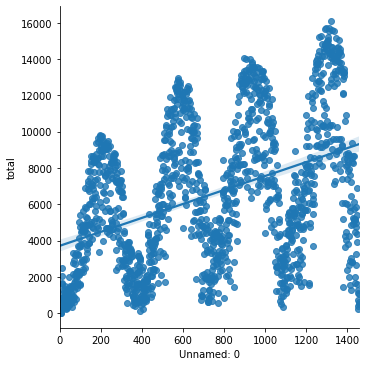

In [1]:
import pandas as pd
import numpy as np
import time 
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
data=pd.read_csv('F:/BaiduNetdiskDownload/archive/data2.csv')
#data=data.drop('Unnamed: 0',axis=1)
#data=data[['starttime','temperature_mean','events','year','month','day','total']]
#data['starttime']=data['starttime'].apply(lambda x : int(time.mktime(time.strptime(x, "%Y-%m-%d"))))
#data['diff_1']
#tdata=data['total'].values.reshape(1458,1)
data['diff_1'] = (data['total']-data['total'].shift(periods=1)).shift(periods=1).fillna(value=0)
data['diff_2'] = (data['total']-data['total'].shift(periods=2)).shift(periods=1).fillna(value=0)



data['per_week_total'] = data['total'].rolling(window=7).sum().fillna(value=0).shift(periods=1).fillna(value=0)
data['per_two_weeks_total'] = data['total'].rolling(window=14).sum().fillna(value=0).shift(periods=1).fillna(value=0)
data['per_30days_total'] = data['total'].rolling(window=30).sum().fillna(value=0).shift(periods=1).fillna(value=0)
data['per_year_total'] = data['total'].rolling(window=365).sum().fillna(value=0).shift(periods=1).fillna(value=0)
sns.lmplot(x='Unnamed: 0',y='total',data=data)
#g = data[['Unnamed: 0','total']].values
#plt.plot(g[:,0],g[:,1])
#plt.xlabel('starttime')
#plt.bar(data['Unnamed: 0'],data['diff_2'])
#plt.show()

In [14]:
data['events'].value_counts()

cloudy          1346
rain or snow      69
clear             41
not clear          2
Name: events, dtype: int64

In [11]:
data[['starttime','year','day','month','events']]=data[['starttime','year','day','month','events']].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   starttime         1458 non-null   category
 1   temperature_mean  1458 non-null   float64 
 2   events            1458 non-null   category
 3   year              1458 non-null   category
 4   month             1458 non-null   category
 5   day               1458 non-null   category
 6   total             1458 non-null   int64   
 7   dayth             1458 non-null   category
 8   festival          1458 non-null   category
 9   isweekend         1458 non-null   category
 10  isholiday         1458 non-null   category
dtypes: category(9), float64(1), int64(1)
memory usage: 91.6 KB


In [4]:
import lightgbm as lgb
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
data=pd.read_csv('F:/BaiduNetdiskDownload/archive/data2.csv')
data=data.drop('Unnamed: 0',axis=1)
data['dayth']=data['starttime'].apply(lambda x : x.split('-')[2]).astype('int64')

#data=data.drop([0,2,3,4,5])
#data=data.set_index(data.starttime)
def festival_d(x):
    if x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'authum'
    else:
        return 'winter'

def weekend_judge(x):
    if (x==5) or (x==6):
        return 1
    else:
        return 0
data['festival']=data['month'].apply(lambda x :festival_d(x))
holidays = [
'2014-01-01','2014-12-25',
'2014-11-11','2014-07-04',
'2014-01-20','2014-02-17',
'2014-03-02','2014-05-26',
'2014-09-01','2014-10-13',
'2014-11-27','2015-01-01',
'2015-12-25','2015-11-11',
'2015-07-04','2015-01-19',
'2015-02-16','2015-03-02',
'2015-05-25','2015-09-07',
'2015-10-12','2015-11-26',
'2016-01-01','2016-12-25',
'2016-11-11','2016-07-04',
'2016-01-18','2016-02-15',
'2016-03-04','2016-05-30',
'2016-09-05','2016-10-10',
'2016-11-24','2017-01-01',
'2017-12-25','2017-11-11',
'2017-07-04','2017-01-16',
'2017-02-20','2017-03-06',
'2017-05-29','2017-09-04',
'2017-10-09','2017-11-23'
]
#data['diff_1'] = (data['total']-data['total'].shift(periods=1).fillna(value=0)).shift(periods=1).fillna(value=0)
#data['diff_2'] = (data['total']-data['total'].shift(periods=2).fillna(value=0)).shift(periods=1).fillna(value=0)
#data['diff_3'] = data['total']-data['total'].shift(periods=3).fillna(value=0)

data['isweekend']=data['starttime'].apply(lambda x : weekend_judge(pd.to_datetime(x).weekday()))
data['isholiday']=data['starttime'].apply(lambda x : 1 if x in holidays else 0)
data['per_week_total'] = data['total'].rolling(window=7).sum().fillna(value=0).shift(periods=1).fillna(value=0)
data['per_two_weeks_total'] = data['total'].rolling(window=14).sum().fillna(value=0).shift(periods=1).fillna(value=0)
data['per_30days_total'] = data['total'].rolling(window=30).sum().fillna(value=0).shift(periods=1).fillna(value=0)

data['per_week_total_mean'] = data['per_week_total'].apply(lambda x :x/7)
data['per_two_weeks_total_mean'] = data['per_two_weeks_total'].apply(lambda x :x/14)
data['per_30days_total_mean'] = data['per_30days_total'].apply(lambda x : x/30)
#data[['per_week_total','per_two_weeks_total','per_30days_total']] = data[['per_week_total','per_two_weeks_total','per_30days_total']].apply(np.log)
evals_result={}
#data['per_year_total'] = data['total'].rolling(window=365).sum().fillna(value=0).shift(periods=1).fillna(value=0)

#for i in range(3):
#
#    data['total_formal'+str(i+1)]=data['total'].shift(periods=i+1).fillna(value=0)
#tmean=data['total'].shift(periods=365).fillna(value=0).mean()
#data['formal365day']=data['total'].shift(periods=365).fillna(value=0)
#data['formal730day']=data['total'].shift(periods=730).fillna(value=0)
#data['formal60day']=data['total'].shift(periods=60).fillna(value=0)


#data['events']=data['events'].astype('category')
#data['starttime_-1']=data['starttime'].shift(periods=1)
data=data.loc[data['total']>200]
data_md=data['month'].astype('str')+'-'+data['dayth'].astype('str')
data['month_dayth'] = data_md
data[['year','day','month','events','isholiday','festival','dayth','isweekend','month_dayth']]=\
    data[['year','day','month','events','isholiday','festival','dayth','isweekend','month_dayth']].astype('category')
data[['per_week_total','per_two_weeks_total','per_30days_total']] = data[['per_week_total','per_two_weeks_total','per_30days_total']].apply(np.log)
data_test = data.loc[(data['year'].astype('int64').isin([2017]))]
data_train = data.loc[(data['year'].astype('int64').isin([2014,2015,2016]))]
X_train,X_test,y_train,y_test =train_test_split(data_train.drop(['total','starttime','month','dayth','year'],axis=1),data_train['total'],test_size=0.2)

#X=data[['starttime','temperature_mean','events','year','month','day','diff_1','diff_2',\
#'per_week_total','per_two_weeks_total','per_30days_total','per_year_total']]
#Y=data['total']
#X_train=X[365:1200]
#X_test=X[1200:]
#y_train=Y[365:1200]
#y_test=Y[1200:]

#X_train,X_test,y_train,y_test =train_test_split(data[['starttime','temperature_mean','events','year','month','day','diff_1','diff_2',\
#'per_week_total','per_two_weeks_total','per_30days_total','total_formal1','total_formal2']],data['total'],test_size=0.2)



lgb_train = lgb.Dataset(X_train, y_train) # 将数据保存到LightGBM二进制文件将使加载更快
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)  # 创建验证数据

params = {
    #'max_depth':6,
    
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'regression', # 目标函数
    'metric': ('l2_root', 'l1'),  # 评估函数
    'num_leaves': 31,   # 叶子节点数
    'learning_rate': 0.001,  # 学习速率
    'feature_fraction': 0.7, # 建树的特征选择比例
    'bagging_fraction': 0.7, # 建树的样本采样比例
    'bagging_freq': 3,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1, # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
     'min_data_in_leaf':20,
    'min_sum_hessian_in_leaf':1e-3,
    'lambda_l1':0,
    'lambda_l2':0,
    'min_split_gain':0
}
print('Start training...')
# 训练 cv and train
gbm = lgb.train(params,lgb_train,num_boost_round=10000,valid_sets=lgb_eval,evals_result=evals_result) # 训练数据需要参数列表和数据集
print('Start predicting...')
# 预测数据集
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration) #如果在训练期间启用了早期停止，可以通过best_iteration方式从最佳迭代中获得预测
# 评估模型
def mape_cal(observe,predict_,shape):

    mape_=(abs(observe-predict_)/observe).sum()*100/shape
    return mape_

Y_pred = gbm.predict(data_test.drop(['total','starttime','year','dayth','month'\
    ],axis=1), num_iteration=gbm.best_iteration) #如果在训练期间启用了早期停止，可以通过best_iteration方式从最佳迭代中获得预测
# 评估模型
Y_test=data_test['total']

mape=mape_cal(y_test,y_pred,y_pred.shape[0])
mape_test=mape_cal(Y_test,Y_pred,Y_pred.shape[0])
print('valid_set prediction:')
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5) # 计算真实值和预测值之间的均方根误差
print('The mae of prediction is:', mean_absolute_error(y_test, y_pred) )
print('The r2_score of prediction is:', r2_score(y_test, y_pred) )
print('The mape of prediction is: '+str(mape)+'%')

print('testing_set prediction:')
print('The rmse of prediction is:', mean_squared_error(Y_test, Y_pred) ** 0.5) # 计算真实值和预测值之间的均方根误差
print('The mae of prediction is:', mean_absolute_error(Y_test, Y_pred) )
print('The r2_score of prediction is:', r2_score(Y_test, Y_pred) )
print('The mape of prediction is: '+str(mape_test)+'%')


valid_0's l1: 872.302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9848]	valid_0's rmse: 1210.73	valid_0's l1: 872.305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9849]	valid_0's rmse: 1210.72	valid_0's l1: 872.294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9850]	valid_0's rmse: 1210.72	valid_0's l1: 872.306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9851]	valid_0's rmse: 1210.75	valid_0's l1: 872.318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9852]	valid_0's rmse: 1210.76	valid_0's l1: 872.334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9853]	valid_0's rmse: 1210.76	valid_0's l1: 872.339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9854]	valid_0's rmse: 1210.79	valid_0's l1: 872.349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9855]	

In [10]:
data_md=data1['month'].astype('str')+'-'+data1['dayth'].astype('str')
data1['month_dayth'] = data_md

<ipython-input-10-546a190d38ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['month_dayth'] = data_md


array([[<AxesSubplot:title={'center':'temperature_mean'}>,
        <AxesSubplot:title={'center':'total'}>,
        <AxesSubplot:title={'center':'per_week_total'}>],
       [<AxesSubplot:title={'center':'per_two_weeks_total'}>,
        <AxesSubplot:title={'center':'per_30days_total'}>,
        <AxesSubplot:title={'center':'per_week_total_mean'}>],
       [<AxesSubplot:title={'center':'per_two_weeks_total_mean'}>,
        <AxesSubplot:title={'center':'per_30days_total_mean'}>,
        <AxesSubplot:>]], dtype=object)

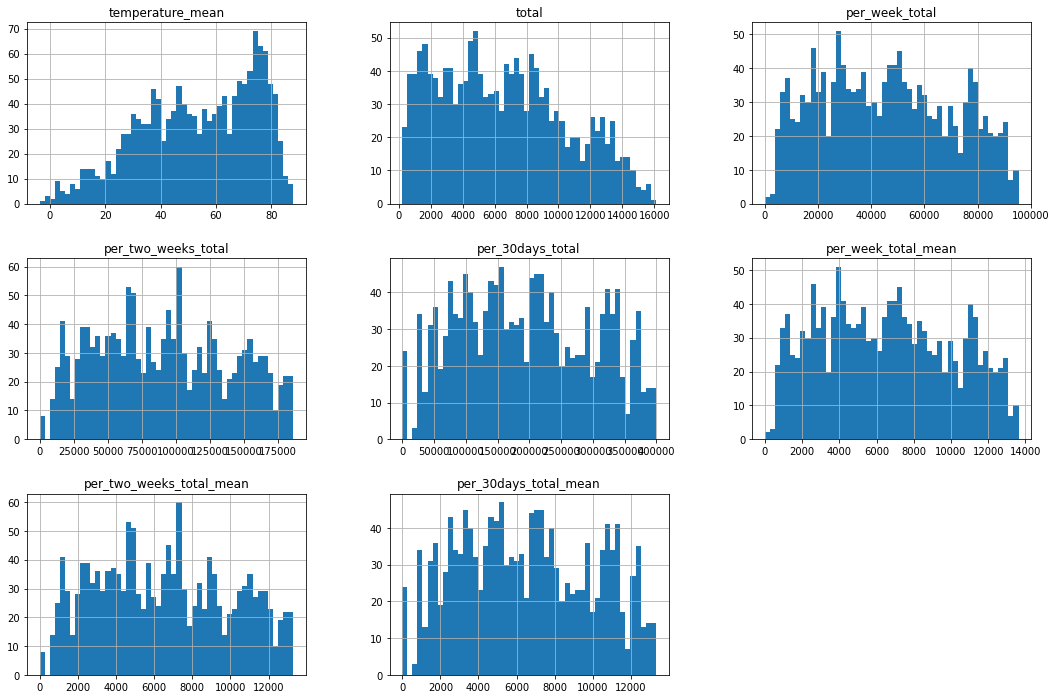

In [2]:
data.hist(bins=50,figsize=(18,12))

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

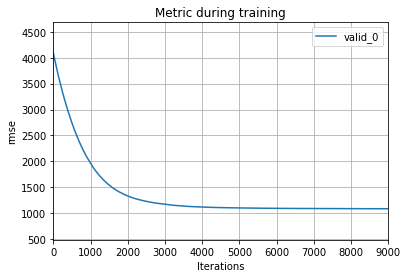

In [3]:
lgb.plot_metric(evals_result,metric='rmse')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

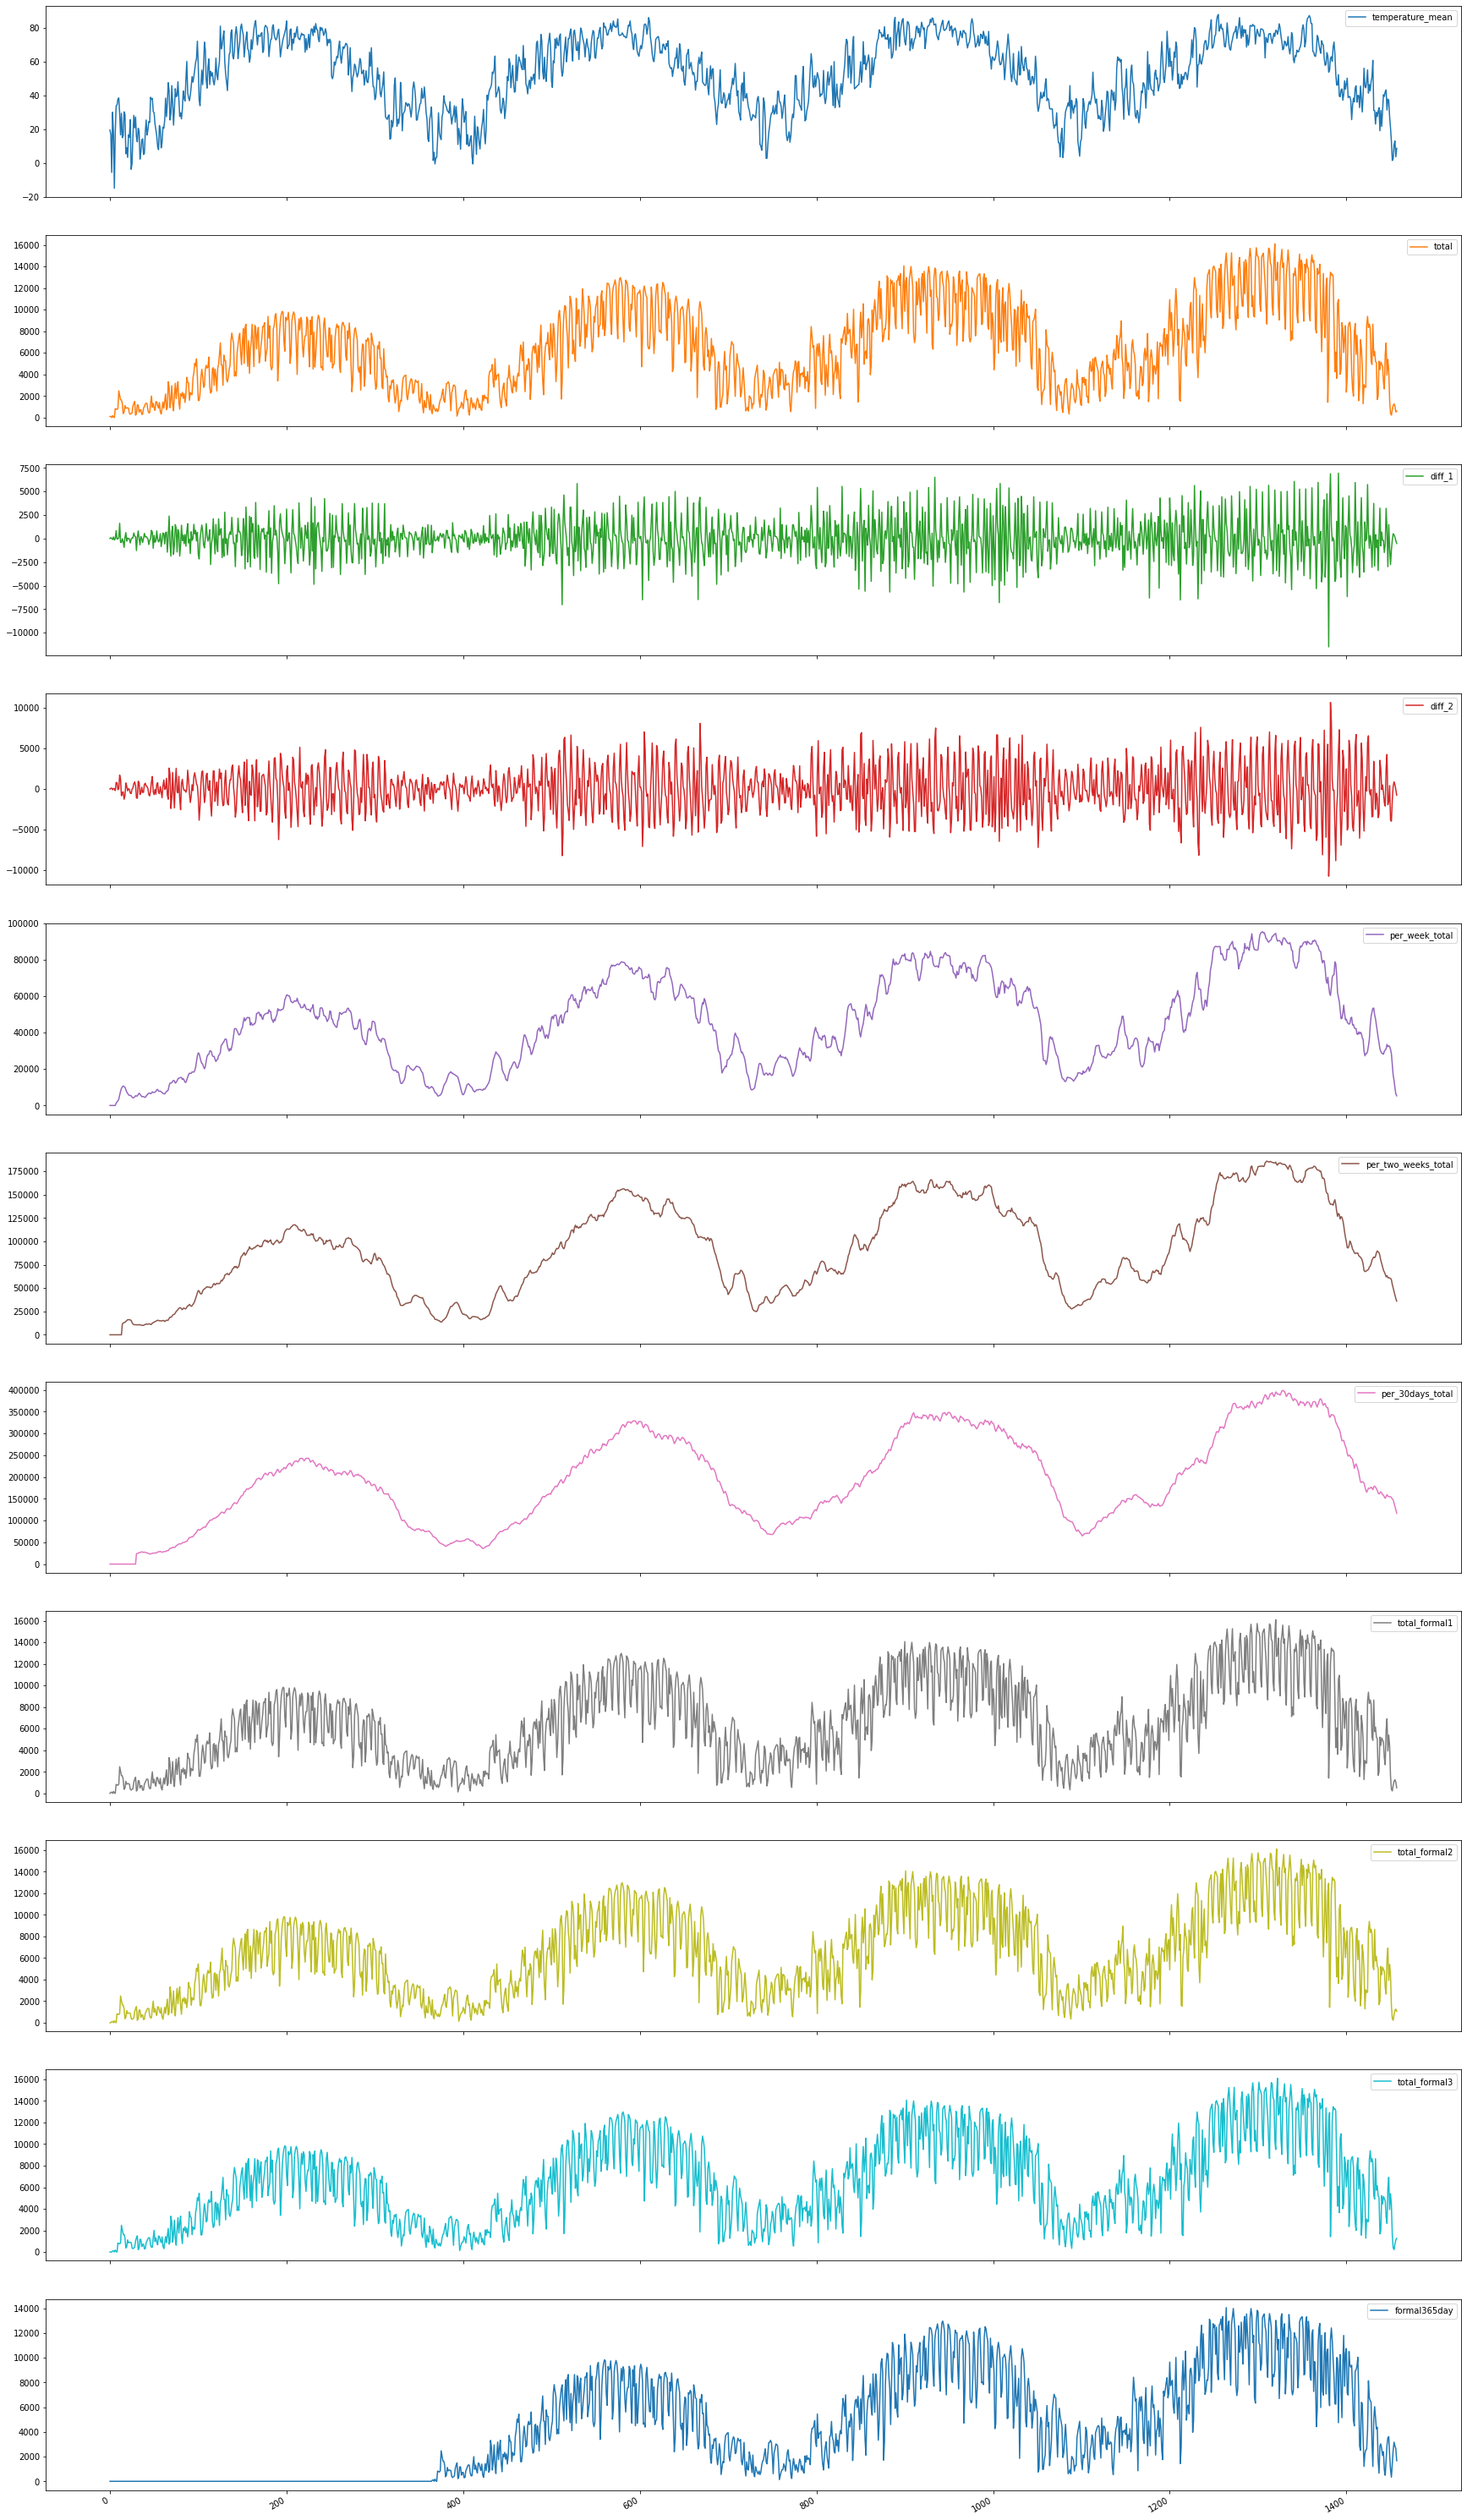

In [8]:
data.plot(subplots=True,figsize=(30,60))

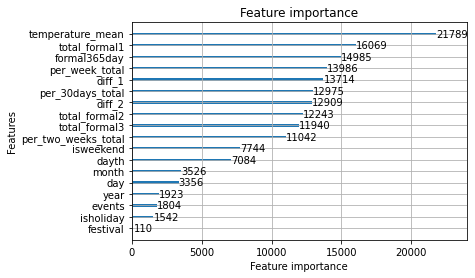

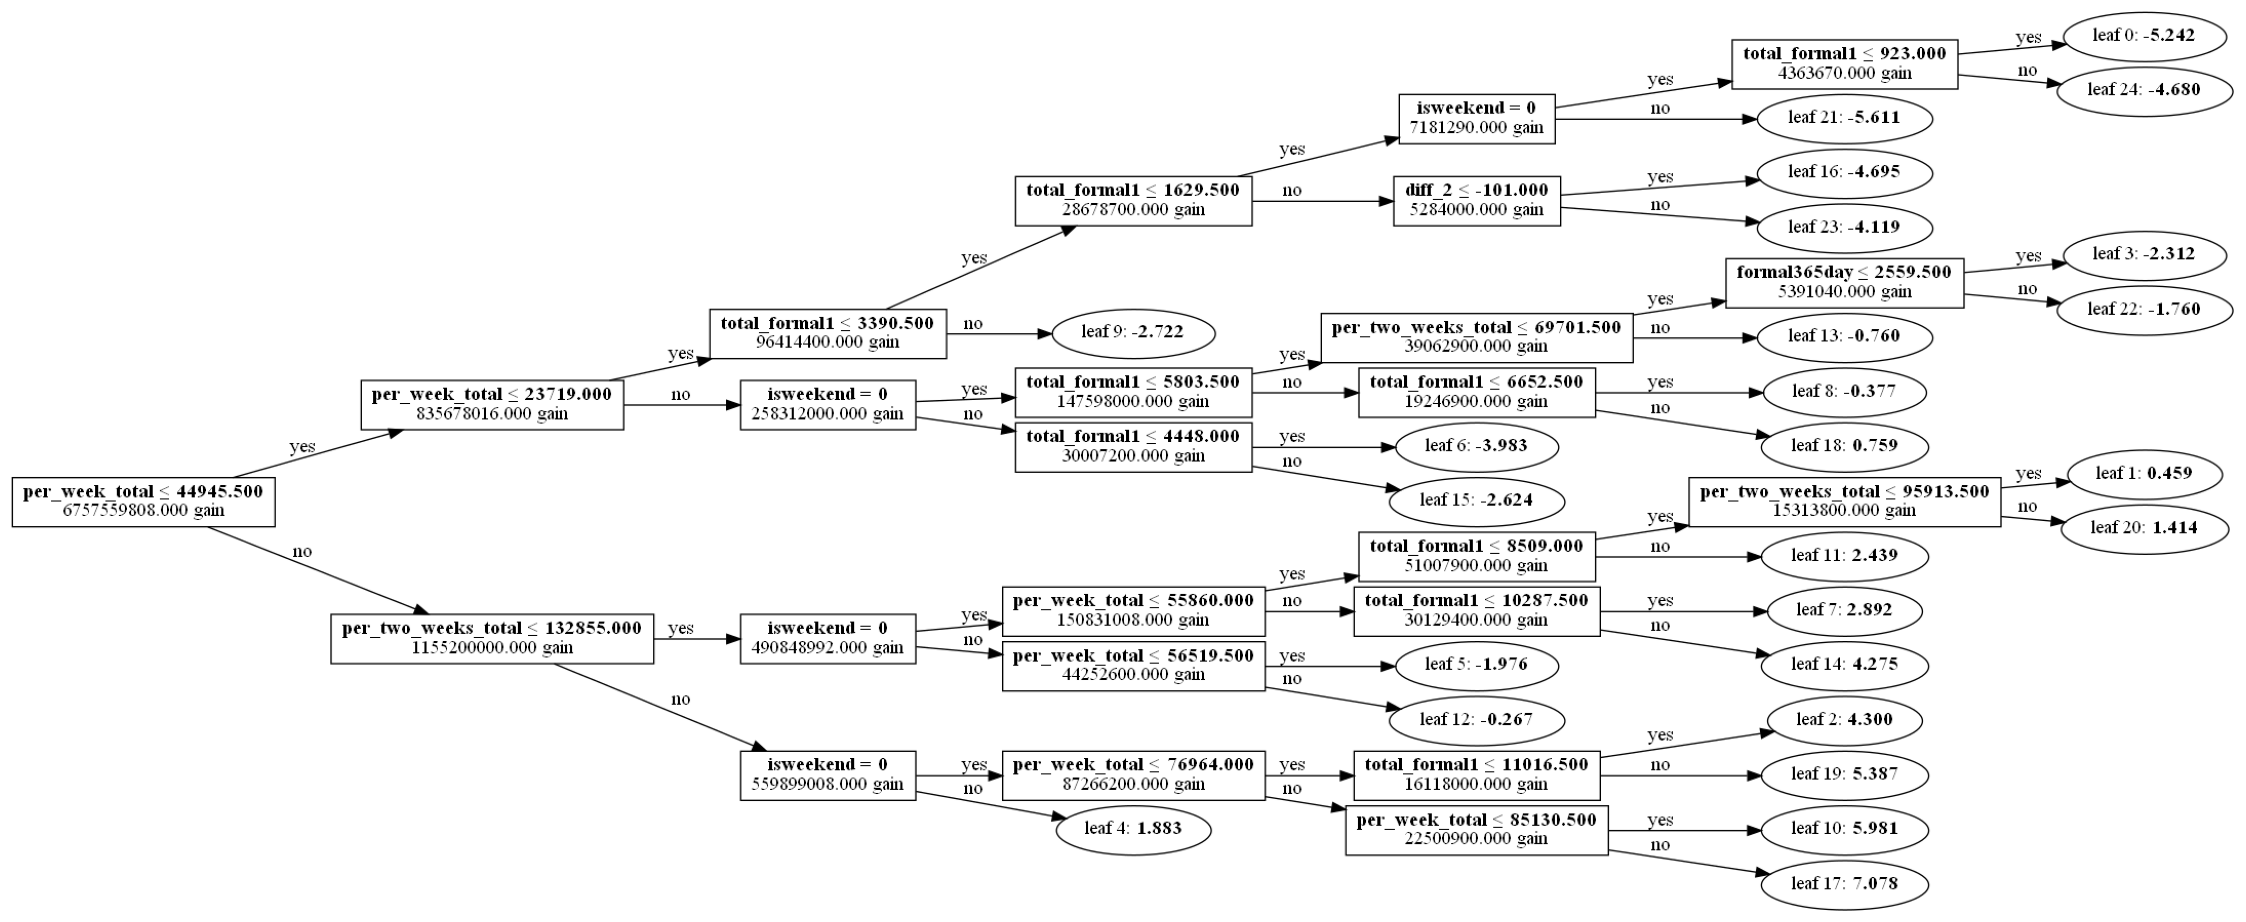

In [25]:
import matplotlib.pyplot as plt
lgb.plot_importance(gbm)
#lgb.plot_metric(gbm)
lgb.plot_tree(gbm,tree_index=1,figsize=(40,30),show_info=['split_gain'])

plt.show()

In [23]:
lgb.plot_tree?

Signature:
lgb.plot_tree(
    booster,
    ax=None,
    tree_index=0,
    figsize=None,
    dpi=None,
    show_info=None,
    precision=3,
    orientation='horizontal',
    **kwargs,
)
Docstring:
Plot specified tree.

Each node in the graph represents a node in the tree.

Non-leaf nodes have labels like ``Column_10 <= 875.9``, which means
"this node splits on the feature named "Column_10", with threshold 875.9".

Leaf nodes have labels like ``leaf 2: 0.422``, which means "this node is a
leaf node, and the predicted value for records that fall into this node
is 0.422". The number (``2``) is an internal unique identifier and doesn't
have any special meaning.

.. note::

    It is preferable to use ``create_tree_digraph()`` because of its lossless quality
    and returned objects can be also rendered and displayed directly inside a Jupyter notebook.

Parameters
----------
booster : Booster or LGBMModel
    Booster or LGBMModel instance to be plotted.
ax : matplotlib.axes.Axes or None, opt

In [18]:
gbm.save_model('D:/new1/model1.txt')

In [13]:
data.describe()

,temperature_mean,total,per_week_total,per_two_weeks_total,per_30days_total,total_formal1,total_formal2,total_formal3
count,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,53.252786,6534.700619,45717.414315,91317.677908,194872.193393,6534.292498,6533.935306,6533.213352
std,20.856486,3940.279506,24652.524178,48811.148045,104036.075084,3940.926009,3941.495069,3942.596342
min,-3.786472,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.445636,3199.000000,25671.000000,51019.000000,106816.000000,3199.000000,3199.000000,3199.000000
50%,55.270484,6196.000000,45202.000000,91018.000000,189929.000000,6196.000000,6196.000000,6196.000000
75%,71.917215,9298.000000,65477.000000,129728.000000,284155.000000,9298.000000,9298.000000,9298.000000
max,87.869579,16095.000000,95397.000000,185920.000000,398977.000000,16095.000000,16095.000000,16095.000000


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   starttime            1458 non-null   object  
 1   temperature_mean     1458 non-null   float64 
 2   events               1458 non-null   category
 3   year                 1458 non-null   category
 4   month                1458 non-null   category
 5   day                  1458 non-null   category
 6   total                1458 non-null   int64   
 7   dayth                1458 non-null   category
 8   festival             1458 non-null   category
 9   isweekend            1458 non-null   category
 10  isholiday            1458 non-null   category
 11  per_week_total       1458 non-null   float64 
 12  per_two_weeks_total  1458 non-null   float64 
 13  per_30days_total     1458 non-null   float64 
 14  total_formal1        1458 non-null   float64 
 15  total_formal2        

In [4]:
y=np.hstack((y_pred.reshape(290,1),y_test.values.reshape(290,1)))
df=pd.DataFrame(y,columns=['total','ture_total'])

df.plot(subplots=True,figsize=(18,12))
df.plot(figsize=(18,12))

ValueError: cannot reshape array of size 219 into shape (290,1)